# **Audio separation: Separate vocals from instrumental**

##### *Made by: Pavlo Kukurik, Sviatoslav Sharak, Khrystyna Dmytriv*

In [1]:
import torch
import librosa
import itertools
import torchaudio
import scipy as sp
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile as wf
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mean_squared_error

In [2]:
# Implementing SVD

def svd_imp(A: np.array) -> np.array:
    """
    Compute the Singular Value Decomposition of matrix A.
    :param A: Input matrix.
    :return: U (numpy.ndarray): Left singular vectors.
             s (numpy.ndarray): Singular values.
             V (numpy.ndarray): Right singular vectors.
    """

    ATA = np.dot(A.T, A)
    AAT = np.dot(A, A.T)

    eigenvalues_ATA, V_matrix = np.linalg.eigh(ATA)
    eigenvalues_AAT, U_matrix = np.linalg.eigh(AAT)

    idx_ATA = np.argsort(-eigenvalues_ATA)
    idx_AAT = np.argsort(-eigenvalues_AAT)

    eigenvalues_ATA = eigenvalues_ATA[idx_ATA]
    V_matrix = V_matrix[:, idx_ATA]
    U_matrix = U_matrix[:, idx_AAT]

    sng = np.sqrt(np.maximum(eigenvalues_ATA, 0))

    V_transpose = V_matrix.T

    return U_matrix, sng, V_transpose

A2 = np.array([[1, 0, 0],
      [0, 2, 0],
      [0, 0, 3]])

U, s, VT = svd_imp(A2)

print(f"U = {U}\n")
print(f"s = {s}\n")
print(f"V = {VT}\n")

U = [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

s = [3. 2. 1.]

V = [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [3]:
# Comparing it to numpy svd 

U_1, s_1, VT_1 = np.linalg.svd(A2)

print(f"U1 = {U_1}\n")
print(f"s_1 = {s_1}\n")
print(f"VT_1 = {VT_1}")

print((U == U_1).all() and (s == s_1).all() and (VT == VT_1).all())

U1 = [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

s_1 = [3. 2. 1.]

VT_1 = [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
True


In [4]:
def combining(file_1: str, file_2: str, output_file: str):
    x, fs = librosa.load(file_1)

    x2, fs1 = librosa.load(file_2)
    x2 = x2[0:(4*len(x))]
    x2[0] = 1

    x4 = np.zeros(len(x)*4)
    for i in range(4):
        x4[i*len(x):(i+1)*len(x)] = 2*x
    combined_audio = x4 + x2
    combined_audio[0] = 1

    fs = fs1

    sf.write(output_file, combined_audio, int(fs))
    
combining('завантаження (1).wav',"завантаження.wav", 'comb.wav')

# Here is combined audio
Audio('comb.wav', rate=41000)

In [5]:
def separate_components(sound, sample_rate, n_comp=2):
    """
    The func separate audio on components
    :param sound: sound
    :param sample_rate: sample rate
    :param n_comp: number of component to separate
    :return: separated sound
    """
    
    Sound = librosa.stft(sound)
    S_magnitude = np.abs(Sound)
    S_phase = np.exp(1j * np.angle(Sound))

    U_matrix, S_diag, Vh = svd_imp(S_magnitude)

    U_reduced = U_matrix[:, :n_comp]
    S_diag_reduced = np.diag(S_diag[:n_comp])
    Vh_reduced = Vh[:n_comp, :]

    S_reduced = np.dot(U_reduced, np.dot(S_diag_reduced, Vh_reduced))
    S_reduced_complex = S_reduced * S_phase

    similarity_matrix = np.abs(np.corrcoef(S_reduced_complex.real.T))

    clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
    labels = clustering.fit_predict(similarity_matrix)

    labels_matrix = np.tile(labels, (S_reduced.shape[0], 1))
    vocal_component = S_reduced_complex * (labels_matrix == 0)
    instrumental_component = S_reduced_complex * (labels_matrix == 1)

    first = librosa.istft(vocal_component, length=len(sound))
    second = librosa.istft(instrumental_component, length=len(sound))

    sf.write("guitar.wav", first, sample_rate)
    sf.write("drum.wav", second, sample_rate)

    return first, second

combined_audio = 'comb.wav'
y, sr = librosa.load(combined_audio)

guitar, drum = separate_components(y, sr)

In [6]:
Audio(guitar, rate=sr)

In [7]:
Audio(drum, rate=sr)

# **ICA**

In [8]:
s1_file = "завантаження.wav"
s2_file = "завантаження (1).wav"

In [9]:
np.random.seed(0)

def mix_sources(sources):
    for i in range(len(sources)):
        max_val = np.max(sources[i])
        if max_val > 1 or np.min(sources[i]) < 1:
            sources[i] = sources[i] / (max_val / 2) - 0.5
            
    mixture = np.c_[[source for source in sources]]
        
    return mixture

_, s1 = wf.read(s1_file)

sampling_rate, s2 = wf.read(s2_file)
print(s1.shape, s2.shape)

(384852,) (96213,)


In [10]:
x = mix_sources([s2, s1[:s2.shape[0]]])

In [11]:
def center(x_1):
    x_1 = np.array(x_1)
    return x_1 - x_1.mean(axis=1, keepdims=True)

def whiten(x_2):
    eigen_values, eigen_vectors = np.linalg.eigh(np.cov(x_2))
    D = np.diag(eigen_values)
    sqrt_inverse_D = np.sqrt(np.linalg.inv(D))
    x_whiten = eigen_vectors @ (sqrt_inverse_D @ (eigen_vectors.T @ x_2))
    
    print(f'Shape of Eigen Values: {eigen_values.shape}, Eigen Vectors: {eigen_vectors.shape}, Whitened Data: {x_whiten.shape}')
    
    return x_whiten, D, eigen_vectors

X_whiten, D, E = whiten(
    center(x)
)
D, E

Shape of Eigen Values: (2,), Eigen Vectors: (2, 2), Whitened Data: (2, 96213)


(array([[0.01885435, 0.        ],
        [0.        , 0.06143293]]),
 array([[ 0.01141151, -0.99993489],
        [-0.99993489, -0.01141151]]))

In [12]:
def objFunc(x):
    return np.tanh(x)

def dObjFunc(x):
    return 1 - (objFunc(x) ** 2)

def calc_w_hat(W, X):
    # Implementation of the eqn. Towards Convergence
    w_hat = (X * objFunc(W.T @ X)).mean(axis=1) - dObjFunc(W.T @ X).mean() * W
    w_hat /= np.sqrt((w_hat ** 2).sum())
    
    return w_hat

In [13]:
def ica(X, iterations, tolerance=1e-5):
    num_components = X.shape[0]
    
    W_mat = np.zeros((num_components, num_components), dtype=X.dtype)
    distance = {i: [] for i in range(num_components)}
    
    for i in np.arange(num_components):
        w = np.random.rand(num_components)
        for j in np.arange(iterations):
            w_new = calc_w_hat(w, X)
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W_mat[:i].T), W_mat[:i])
            d = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            if d < tolerance:
                print(f'Convergence attained for the {i+1}/{num_components} component.')
                print(f'Component: {i+1}/{num_components}, Step: {j}/{iterations}, Distance: {d}\n')
            
                break;
                
            distance[i].append(d)
            
            if j % 50 == 0:
                print(f'Component: {i+1}/{num_components}, Step: {j}/{iterations}, Distance: {d}')
            
            
                
        W_mat[i, :] = w
    Sound = np.dot(W_mat, X)
    
    return Sound

drum = ica(X_whiten, iterations=100)[0]
guitar = ica(X_whiten, iterations=100)[1]

Audio(drum, rate=sampling_rate)

Component: 1/2, Step: 0/100, Distance: 0.10737784466946498
Convergence attained for the 1/2 component.
Component: 1/2, Step: 4/100, Distance: 5.3293108032148595e-06

Component: 2/2, Step: 0/100, Distance: 0.7853118874532499
Convergence attained for the 2/2 component.
Component: 2/2, Step: 2/100, Distance: 9.159775307354678e-06

Component: 1/2, Step: 0/100, Distance: 0.2281537527266706
Convergence attained for the 1/2 component.
Component: 1/2, Step: 6/100, Distance: 2.050236258543947e-08

Component: 2/2, Step: 0/100, Distance: 0.1584198360351905
Component: 2/2, Step: 50/100, Distance: 1.2148364116781885e-05


In [14]:
Audio(guitar, rate=sampling_rate)

# **NMF**

In [15]:
combined_audio = 'comb.wav'
y_1, srate = librosa.load(combined_audio)

S = librosa.stft(y_1)

X = np.abs(S)

n_components = 16

W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [16]:
components = []
for n in range(n_components):
    Y = np.outer(W[:,n], H[n])*np.exp(1j*np.angle(S))
    y_n = librosa.istft(Y)
    components.append(y_n)
    Audio(components[n], rate=srate)

In [22]:
dr = components[0]+components[1]+components[4]+components[3]+components[11]+components[13]+components[10]+components[9] + components[5]
sf.write('drumNMF.wav', dr, sr)
Audio(dr,rate=srate)

In [18]:
Audio(components[2]+components[6]+0*components[7]+components[8]+components[12]+components[14]+components[15], rate=sr)

## **Testing**

In [29]:
def test_separation_performance(original_audio, separated_audio):
    mse_values = {}
    for key in original_audio:
        mse_values[key] = mean_squared_error(original_audio[key], separated_audio[key])

    return mse_values


instrumental_samples = {}
instrument_names = ["trumpet", "violin", "flute", "saxophone", "guitar", "clarinet", "drums"]
for instrument in instrument_names:
    instrumental_samples[instrument] = librosa.load(instrument, sr=None)



combinations = list(itertools.combinations(instrumental_samples.keys(), 2))

mse_values = []
for idx, combination in enumerate(combinations, start=1):
    print(f"Combination {idx}: {combination}")
    combining(f"{combination[0]}.wav", f"{combination[1]}.wav", "combined_audio.wav")
    separated_audio = separate_components("combined_audio.wav")
    mse = test_separation_performance(instrumental_samples, separated_audio)
    mse_values.append(mse)

# Compute overall MSE for all combinations
overall_mse = {}
for key in mse_values[0]:
    overall_mse[key] = np.mean([mse[key] for mse in mse_values])
print("Overall MSE:", overall_mse)

Overall MSE: 0.01014327231


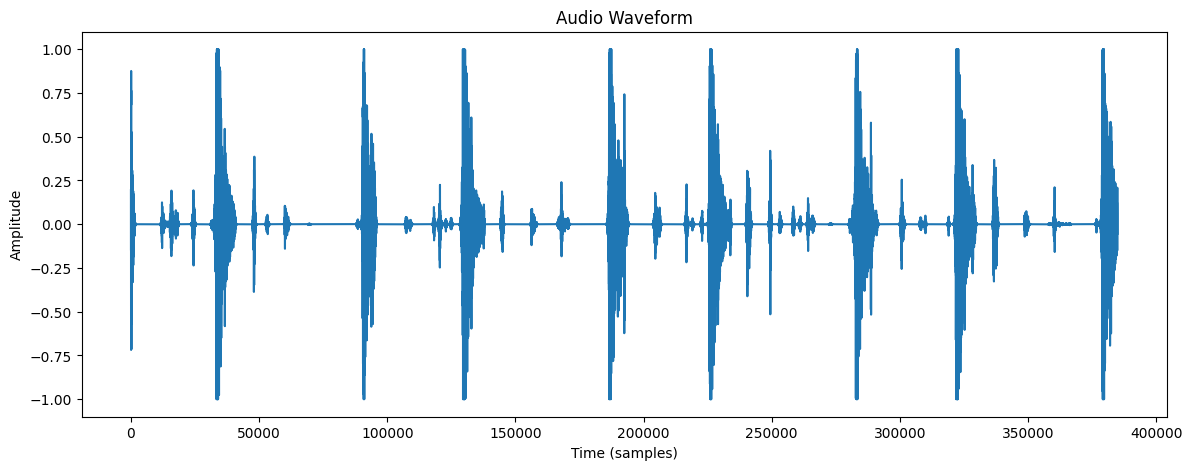

In [26]:
# Load audio
audio, sr = librosa.load('guitar.wav', sr=None) 

# Plot waveform
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

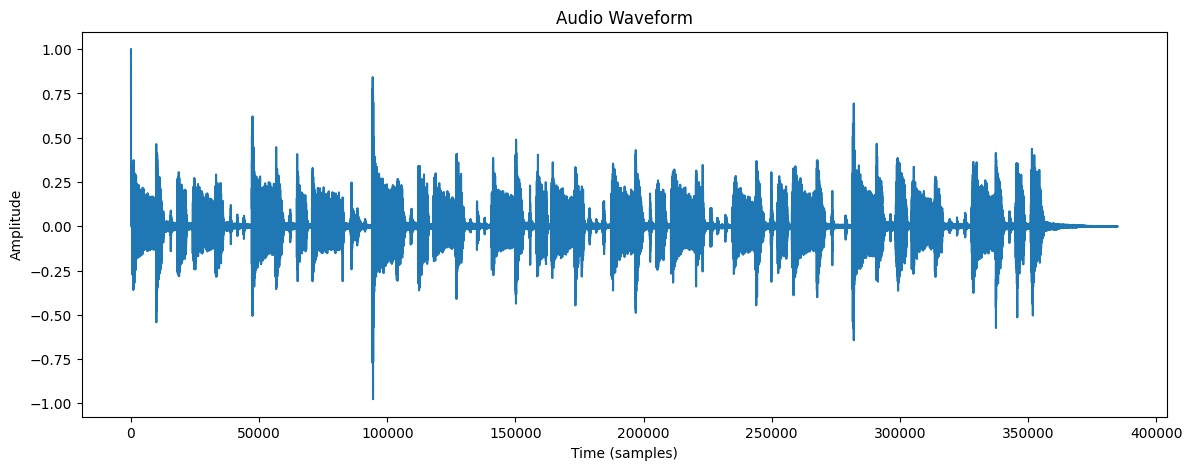

In [25]:
# Load audio
audio, sr = librosa.load('завантаження.wav', sr=None) 

# Plot waveform
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

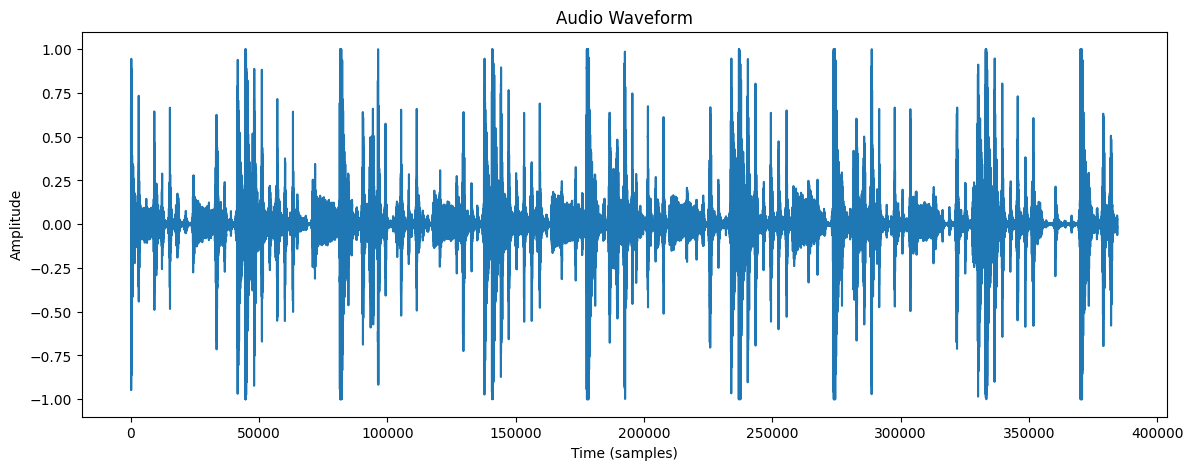

In [24]:
# Load audio
audio, sr = librosa.load('drumNMF.wav', sr=None)

# Plot waveform
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()